In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#function to convert dataframe to into 2d array
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame;

In [21]:
#view of a sample of data
df=pd.read_csv("/content/drive/My Drive/dataset/A1Benchmark/real_1.csv")
df.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [0]:
#for concatenating all the files and
#Preprocessing the data
from sklearn import preprocessing
import glob
path = r'/content/drive/My Drive/dataset/A1Benchmark' #set the path accordingly
all_files=glob.glob(path+"/*.csv")

dataset_conc=[]
for filename in all_files:
  df=pd.read_csv(filename,index_col=None,header=0)
  df=df.replace(0,np.nan)
  df=df.dropna(axis=0, how='any',subset=['value'])
  df.value = preprocessing.normalize([df.value]).T
  dataset_conc.append(convert_2d(df)) 
frame=pd.concat(dataset_conc,axis=0,ignore_index=True)


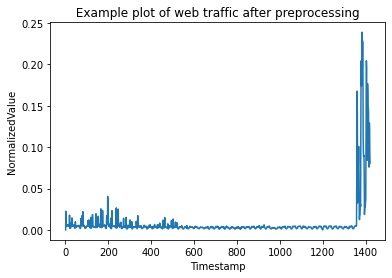

In [5]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Flatten,MaxPooling1D,Conv1D,LSTM
from keras import optimizers

Using TensorFlow backend.


In [8]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
model.add(LSTM(64, activation='tanh',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 60, 64)            384       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 960)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             262400    
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)               

In [9]:
frame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.035790,0.030838,0.031739,0.035565,0.032189,0.031739,0.034215,0.029037,0.034215,0.033314,0.026561,0.028587,0.027912,0.029713,0.027237,0.026786,0.027912,0.023410,0.029488,0.026111,0.029037,0.030388,0.031739,0.030613,0.027687,0.028137,0.032639,0.026111,0.031514,0.029488,0.024761,0.025886,0.028362,0.028812,0.025886,0.026111,0.027462,0.029263,0.026336,0.027012,0.024085,0.022960,0.023410,0.024310,0.022960,0.025661,0.025661,0.026111,0.021834,0.028137,0.024761,0.026786,0.025211,0.032414,0.028812,0.032864,0.029488,0.032414,0.029938,0.029713,0.0
1,0.030838,0.031739,0.035565,0.032189,0.031739,0.034215,0.029037,0.034215,0.033314,0.026561,0.028587,0.027912,0.029713,0.027237,0.026786,0.027912,0.023410,0.029488,0.026111,0.029037,0.030388,0.031739,0.030613,0.027687,0.028137,0.032639,0.026111,0.031514,0.029488,0.024761,0.025886,0.028362,0.028812,0.025886,0.026111,0.027462,0.029263,0.026336,0.027012,0.024085,0.022960,0.023410,0.024310,0.022960,0.025661,0.025661,0.026111,0.021834,0.028137,0.024761,0.026786,0.025211,0.032414,0.028812,0.032864,0.029488,0.032414,0.029938,0.029713,0.029938,0.0
2,0.031739,0.035565,0.032189,0.031739,0.034215,0.029037,0.034215,0.033314,0.026561,0.028587,0.027912,0.029713,0.027237,0.026786,0.027912,0.023410,0.029488,0.026111,0.029037,0.030388,0.031739,0.030613,0.027687,0.028137,0.032639,0.026111,0.031514,0.029488,0.024761,0.025886,0.028362,0.028812,0.025886,0.026111,0.027462,0.029263,0.026336,0.027012,0.024085,0.022960,0.023410,0.024310,0.022960,0.025661,0.025661,0.026111,0.021834,0.028137,0.024761,0.026786,0.025211,0.032414,0.028812,0.032864,0.029488,0.032414,0.029938,0.029713,0.029938,0.029488,0.0
3,0.035565,0.032189,0.031739,0.034215,0.029037,0.034215,0.033314,0.026561,0.028587,0.027912,0.029713,0.027237,0.026786,0.027912,0.023410,0.029488,0.026111,0.029037,0.030388,0.031739,0.030613,0.027687,0.028137,0.032639,0.026111,0.031514,0.029488,0.024761,0.025886,0.028362,0.028812,0.025886,0.026111,0.027462,0.029263,0.026336,0.027012,0.024085,0.022960,0.023410,0.024310,0.022960,0.025661,0.025661,0.026111,0.021834,0.028137,0.024761,0.026786,0.025211,0.032414,0.028812,0.032864,0.029488,0.032414,0.029938,0.029713,0.029938,0.029488,0.027687,0.0
4,0.032189,0.031739,0.034215,0.029037,0.034215,0.033314,0.026561,0.028587,0.027912,0.029713,0.027237,0.026786,0.027912,0.023410,0.029488,0.026111,0.029037,0.030388,0.031739,0.030613,0.027687,0.028137,0.032639,0.026111,0.031514,0.029488,0.024761,0.025886,0.028362,0.028812,0.025886,0.026111,0.027462,0.029263,0.026336,0.027012,0.024085,0.022960,0.023410,0.024310,0.022960,0.025661,0.025661,0.026111,0.021834,0.028137,0.024761,0.026786,0.025211,0.032414,0.028812,0.032864,0.029488,0.032414,0.029938,0.029713,0.029938,0.029488,0.027687,0.029713,0.0


In [0]:
#train test split
y=frame.iloc[:, 60]
X=frame.iloc[:, 0:60]
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [0]:
#reshaping the data 
X_train=X_train.to_numpy()
nrows, ncols = X_train.shape
X_train = X_train.reshape(nrows, ncols, 1)

X_test=X_test.to_numpy()
nrows, ncols = X_test.shape
X_test = X_test.reshape(nrows, ncols, 1)

y_test = y_test.to_numpy()


In [0]:
#converting y_train to categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train)

In [0]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)


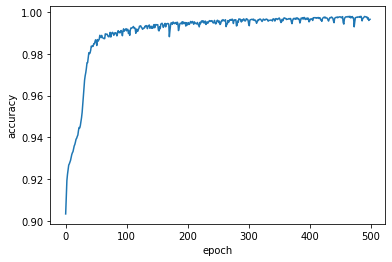

In [22]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [14]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


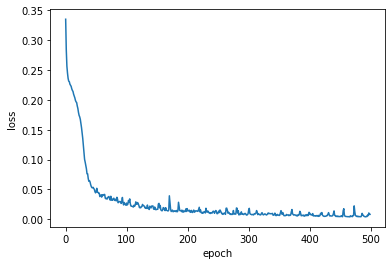

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
 #predicting on test data
y_pred=model.predict_classes(X_test)

In [0]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred)
Accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
F1_Score = f1_score(y_test, y_pred, average='binary')

In [18]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[22955  1230]
 [  704  1729]]
Accuracy  0.9273423998797806
Precision  0.5843190266982089
recall  0.7106452938758734
f1_score  0.6413204747774481
